# main

Here, a squirmer-bead-bead chain built with linear bonds is simulated. In addition, an angular bond keeps the angle of the molecule fixed.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
import auxiliary as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 0
dataDir = f'../data.lbm/0{src_n}/'
# dataDir = f'../src/0{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

100

# Fluid

In [4]:
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")

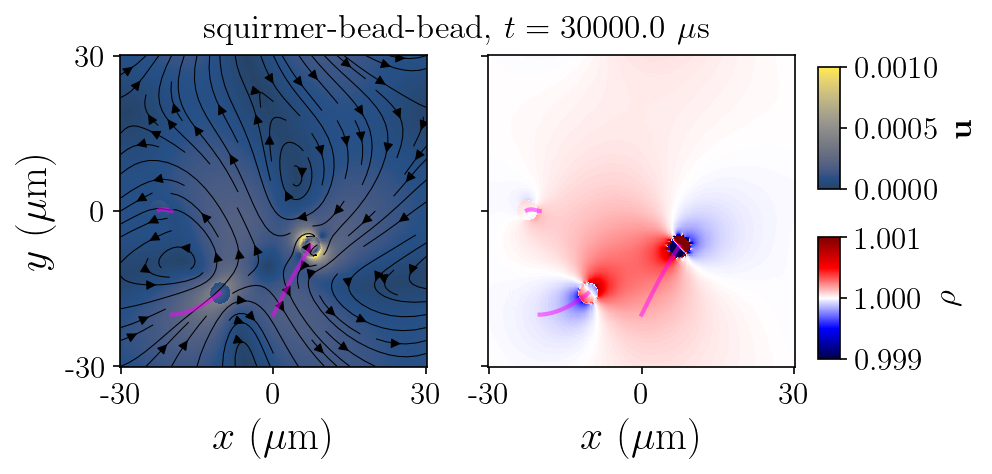

In [5]:
title = f'squirmer-bead-bead, $t = {fluidDf.time.values[-1]:0.1f}$'+' $\\mu \\mathrm{s}$'
fig, axes = aux.fluidOverview(fluidDf, particleDf, title)
plt.show()

In [6]:
id = 1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")

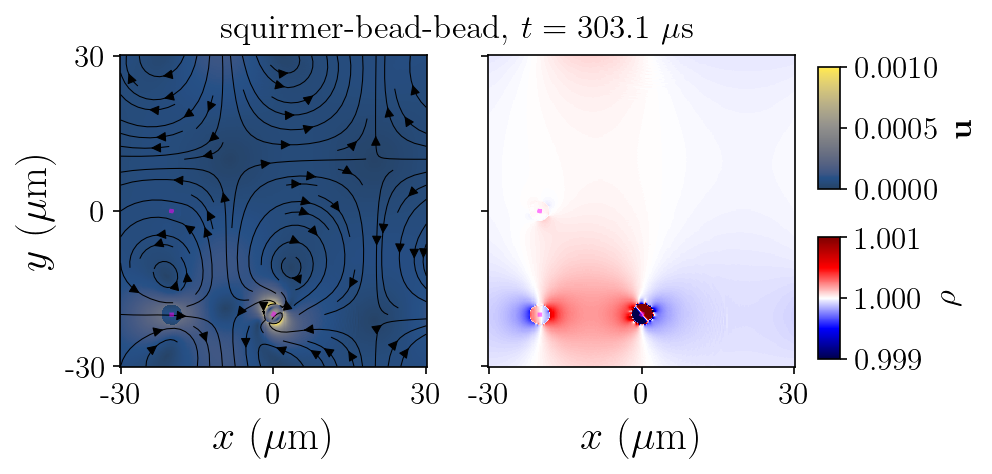

In [7]:
title = f'squirmer-bead-bead, $t = {fluidDf.time.values[-1]:0.1f}$'+' $\\mu \\mathrm{s}$'
fig, axes = aux.fluidOverview(fluidDf, particleDf, title)
plt.show()

# particles

Due to the bonds, $\mathbf{r}_{12}$ and $\mathbf{r}_{23}$ must have remained roughly constant; they're bound by a harmonic potential. Moreover, there are no torsion bonds, so $\angle \mathbf{x}_1\mathbf{x}_2\mathbf{x}_3$ must change freely.

> **Note:** $\mathbf{r}_{ij} \equiv \mathbf{x}_i - \mathbf{x}_j$ is the separation vector between particles $i$ and $j$.

In [8]:
x1 = [particleDf.query("particleId == 1").position_x.values, particleDf.query("particleId == 1").position_y.values]
x2 = [particleDf.query("particleId == 2").position_x.values, particleDf.query("particleId == 2").position_y.values]
x3 = [particleDf.query("particleId == 3").position_x.values, particleDf.query("particleId == 3").position_y.values]

r12 = [x1[0] - x2[0], x1[1] - x2[1]]
r32 = [x3[0] - x2[0], x3[1] - x2[1]]

latticeParameter = fluidDf.coordinate_x.unique()[1] - fluidDf.coordinate_x.unique()[0]

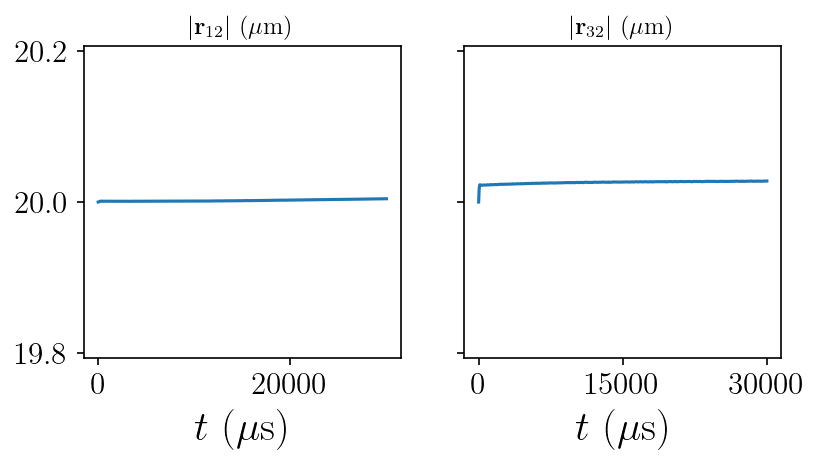

In [23]:
fig, axes = plt.subplots(1,2, figsize=(6,2.7))

axes[0].plot(
    particleDf.time.unique(),
    np.sqrt(r12[0]**2 + r12[1]**2)
)
axes[0].set_ylim(20-latticeParameter, 20+latticeParameter)
axes[0].set_xlabel("$t ~ (\\mu \\mathrm{s})$")
axes[0].set_title("$|\\mathbf{r}_{12}| ~ (\\mu \\mathrm{m})$")

axes[1].plot(
    particleDf.time.unique(),
    np.sqrt(r32[0]**2 + r32[1]**2)
)
axes[1].tick_params(labelleft=False)
axes[1].set_ylim(20-latticeParameter, 20+latticeParameter)
axes[1].set_xticks([0,15e3,30e3])
axes[1].set_xlabel("$t ~ (\\mu \\mathrm{s})$")
axes[1].set_title("$|\\mathbf{r}_{32}| ~ (\\mu \\mathrm{m})$")

plt.show()

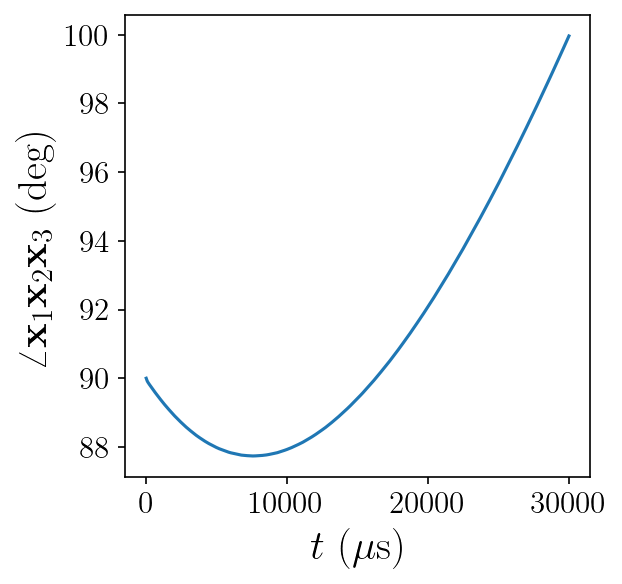

In [11]:
plt.plot(
    particleDf.time.unique(),
    np.acos(
        (r12[0]*r32[0] + r12[1]*r32[1]) / (
            np.sqrt(r12[0]*r12[0] + r12[1]*r12[1]) * np.sqrt(r12[0]*r12[0] + r12[1]*r12[1])
        )
        
    ) * 180/np.pi
)

plt.xlabel("$t ~ (\\mu \\mathrm{s})$")
plt.ylabel("$\\angle \\mathbf{x}_1 \\mathbf{x}_2 \\mathbf{x}_3 ~ (\\mathrm{deg})$")

plt.show()

# Stability analysis

In [12]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [13]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

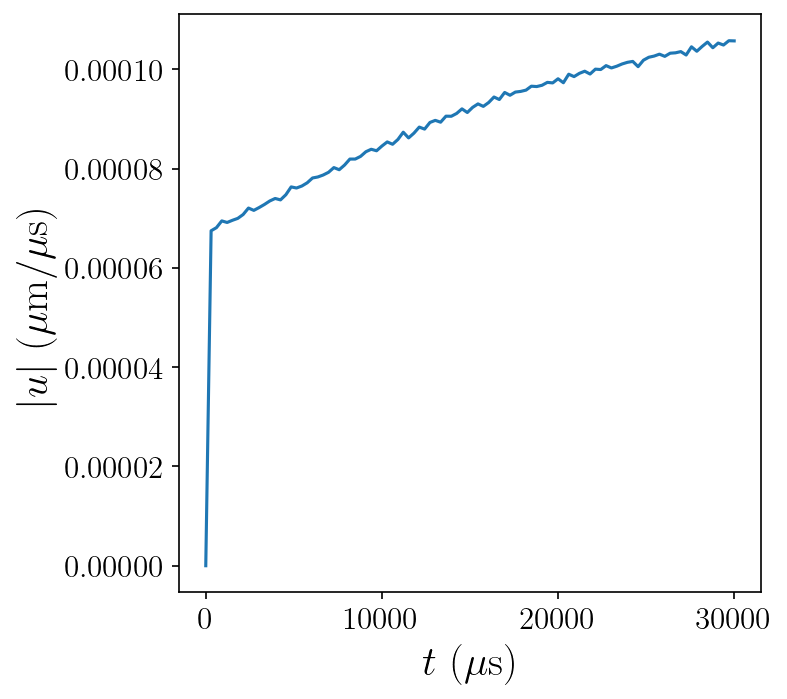

In [14]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()

# Animation

In [24]:
# necessary directories are created
outputDir = f"frames.{src_n}"
os.system(f'mkdir -p anims')
os.system(f'mkdir {outputDir}')

# the data is read and frames are saved
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
for tickId in np.arange(len(ticks)):
    fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[tickId]}.csv").set_index(["id_x","id_y"]).sort_index()
    title = f'squirmer-bead-bead, $t = {fluidDf.time.values[-1]:.0f}$'+' $\\mu \\mathrm{s}$'
    fig, axes = aux.fluidOverview(fluidDf, particleDf, title)

    plt.savefig(f"{outputDir}/{tickId}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f'\r{tickId}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

# ffmpeg is used to create the animation
mkAnimSh = f'ffmpeg -framerate 25 -i {outputDir}/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}.mp4'
os.system(mkAnimSh)

# the directory with the frames is erased
os.system(f'rm -r {outputDir}')

0